In [1]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the module from the examples directory
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import vmap
from functools import partial
from scipy.spatial import distance_matrix
from l2ws.utils.nn_utils import get_nearest_neighbors
from l2ws.l2ws_model import L2WSmodel
from l2ws.algo_steps import create_train_fn, create_eval_fn, cold_start_solve

/Users/rajivs/Documents/Princeton/l2ws_conic/env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Projected gradient descent

<!-- &\\ \quad z \in \mathcal{C} -->

In this tutorial we show how to use our package to learn high-quality warm starts for your favorite fixed-point algorithm.
We consider projected gradient descent to solve the problem

\begin{equation*}
\begin{array}{ll} \text{minimize} &f_\theta(z)\\
\text{subject to} & z \in \mathcal{C},
 \end{array}
\end{equation*}
where $z \in \mathbf{R}^n$ is the decision variable, $f_\theta : \mathbf{R}^n \rightarrow \mathbf{R}$ is a convex function and $L$-smooth function.

The iterates of projected gradient descent are
\begin{equation*}
    z^{i+1} = \Pi_{\mathcal{C}}(z^i - \alpha \nabla f_\theta(z^i)).
\end{equation*}

We take the specific example of non-negative least squares

\begin{equation*}
\begin{array}{ll} \text{minimize} &\|Az-b\|_2^2\\
\text{subject to} & z \geq 0,
 \end{array}
\end{equation*}
where $A \in \mathbf{R}^{m \times n}$ and $b \in \mathbf{R}^{m}$ are problem data.
Here, $\theta = b$ is the parameter.

In [2]:
# setup
N_train = 5000
N_test = 100
N = N_train + N_test
m, n = 50, 25

# generate a single random A matrix
A = jnp.array(np.random.normal(size=(m, n)))

# generate N different b vectors
b_mat = jnp.array(np.random.normal(size=(N, m)))

k = 500
z0 = jnp.zeros(n)
evals, evecs = jnp.linalg.eigh(A.T @ A)
step = 1 / jnp.max(evals)

# setup inputs
b_mat_train = b_mat[:N_train, :]
b_mat_test = b_mat[N_train:, :]
train_inputs = b_mat_train
test_inputs = b_mat_test

In [3]:
# code up the fixed-point algorithm
def proj_gd_fixed_point(z, theta):
    return jnp.clip(z - step * A.T @ (A @ z - theta), a_min=0)

train_fn_proj_gd = create_train_fn(proj_gd_fixed_point)
eval_fn_proj_gd = create_eval_fn(proj_gd_fixed_point)

In [4]:
# solve all of the problems to get z_stars_train and z_stars_test
# batch_train_fn_proj_gd = vmap(train_fn_proj_gd, in_axes=(None, 0, 0, None, None, None), out_axes=(0, 0))
# z0_init_mat = jnp.zeros((N, n))
# z_finals, iter_losses = batch_train_fn_proj_gd(1000, z0_init_mat, b_mat, False, None, False)

# z_finals, iter_losses = cold_start_solve(b_mat)
z_finals, iter_losses = cold_start_solve(proj_gd_fixed_point, n, b_mat)

z_stars_train = z_finals[:N_train, :]
z_stars_test = z_finals[N_train:, :]

In [5]:
# create a ProjGDmodel object that inherits from the L2WSmodel
class ProjGDmodel(L2WSmodel):
    def __init__(self, input_dict):
        super(ProjGDmodel, self).__init__(input_dict)

    def initialize_algo(self, input_dict):
        self.algo = 'proj_gd'

        # in some algorithms (.e.g, SCS and OSQP), we need to factor matrices. Here we don't need any factorization
        #   and set the following
        self.factors_required = False
        self.factor_static = None
        
        # now set the parameters
        self.q_mat_train, self.q_mat_test = input_dict['b_mat_train'], input_dict['b_mat_test']
        self.output_size = n

        self.train_fn = partial(train_fn_proj_gd, jit=self.jit)
        self.eval_fn = partial(eval_fn_proj_gd, jit=self.jit)
        self.out_axes_length = 4


In [6]:
# create l2ws_model
nn_cfg = {'lr': 1e-3, 'method': 'adam', 'intermediate_layer_sizes': [100]}
train_unrolls = 15
supervised = False
input_dict = dict(algorithm='proj_gd',
                    supervised=supervised,
                    train_unrolls=train_unrolls, 
                    jit=True,
                    train_inputs=train_inputs, 
                    test_inputs=test_inputs,
                    b_mat_train=b_mat_train, 
                    b_mat_test=b_mat_test,
                    nn_cfg=nn_cfg,
                    z_stars_train=z_stars_train,
                    z_stars_test=z_stars_test,
                    )
proj_gd_model = ProjGDmodel(input_dict)

In [7]:
# cold start evaluation
k = 100
init_eval_out = proj_gd_model.evaluate(
    k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
init_test_losses = init_eval_out[1][1].mean(axis=0)

In [8]:
# full evaluation on the test set with nearest neighbor
nearest_neighbors_z = get_nearest_neighbors(train_inputs, test_inputs, z_stars_train)
nn_eval_out = proj_gd_model.evaluate(k, nearest_neighbors_z,
                                    b_mat_test, z_stars=z_stars_test,
                                    fixed_ws=True, tag='test')
nn_losses = nn_eval_out[1][1].mean(axis=0)

In [9]:
# train the proj_gd_model
params, state = proj_gd_model.params, proj_gd_model.state
num_epochs = 1000
train_losses = jnp.zeros(num_epochs)
for i in range(num_epochs):
    train_result = proj_gd_model.train_full_batch(params, state)
    loss, params, state = train_result
    train_losses = train_losses.at[i].set(loss)

proj_gd_model.params, proj_gd_model.state = params, state

# full evaluation on the test set
final_eval_out = proj_gd_model.evaluate(
    k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_test_losses = final_eval_out[1][1].mean(axis=0)

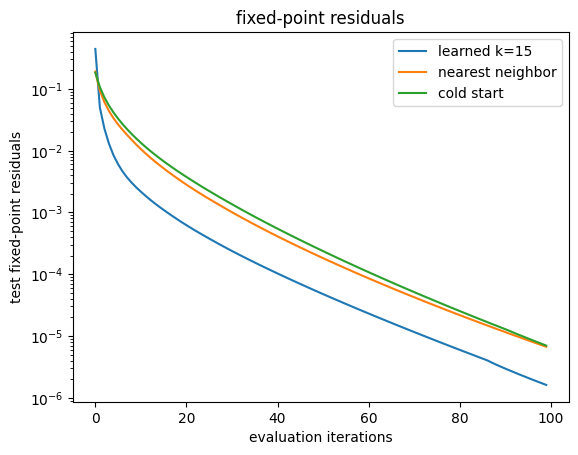

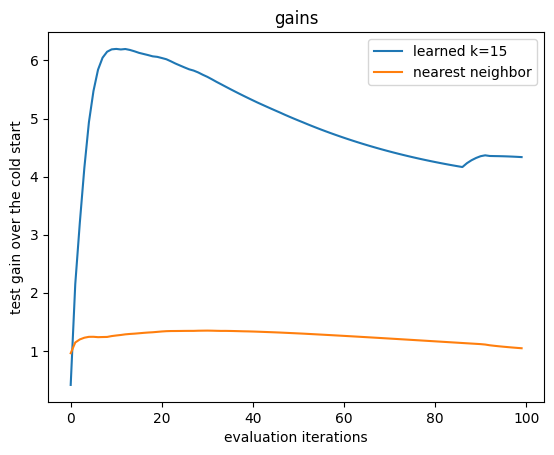

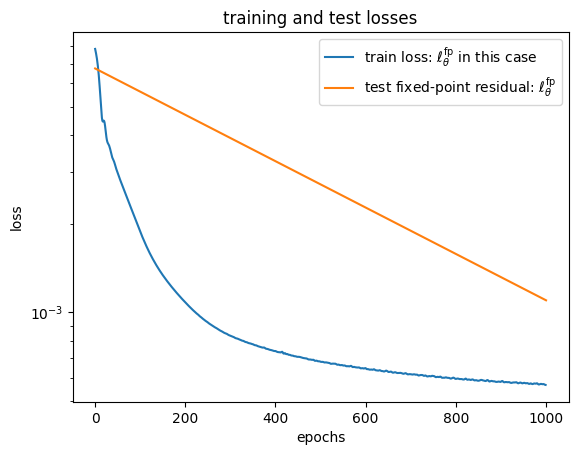

In [11]:
plt.plot(final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(nn_losses, label='nearest neighbor')
plt.plot(init_test_losses, label='cold start')
plt.yscale('log')
plt.title('fixed-point residuals')
plt.ylabel('test fixed-point residuals')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

plt.plot(init_test_losses / final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(init_test_losses / nn_losses, label='nearest neighbor')
plt.title('gains')
plt.ylabel('test gain over the cold start')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

label=r'train loss: $\ell^{\rm reg}_\theta$ in this case' if supervised else r'train loss: $\ell^{\rm fp}_\theta$ in this case'
plt.plot(train_losses, label=label)
plt.yscale('log')
test_losses = np.array([init_test_losses[train_unrolls], final_test_losses[train_unrolls]])
epochs_array = np.array([0, num_epochs])

test_label = r'test fixed-point residual: $\ell^{\rm fp}_\theta$'
plt.plot(epochs_array, test_losses, label=test_label)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.title('training and test losses')
plt.legend()
plt.show()